## Chapter 5: Fine-Tuning with `SFTTrainer`


### Spoilers

In this chapter, we will:

- Understand why it’s often difficult to prevent out-of-memory errors from occurring during training
- Explore a range of configuration settings that can help you get the maximum use out of your GPU’s RAM
- Use the `SFTTrainer` class from trl to fine-tune a model
- Discuss the advantages of memory-efficient attention implementations (such as Flash Attention 2 and PyTorch’s SDPA)

### Setup

In [ ]:
# If you're running on Colab
!pip install datasets bitsandbytes trl

In [ ]:
# If you're running on runpod.io's Jupyter Template
#!pip install transformers peft huggingface-hub accelerate safetensors pandas matplotlib

### Imports

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from peft import get_peft_model, prepare_model_for_kbit_training, LoraConfig, AutoPeftModelForCausalLM
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from trl import SFTTrainer, SFTConfig, setup_chat_format, DataCollatorForCompletionOnlyLM

In [ ]:
# If you're running on Colab, you need to download the helper functions' Python file
!wget https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs/refs/heads/main/helper_functions.py
    
from helper_functions import *

### The Goal

We pull out all the stops to squeeze the base model, the adapters, the optimizer, and a mini-batch into the GPU's RAM with enough room left to fit the computed activations and the gradients. We manage to make it work by trading computing for memory (gradient checkpointing), deferring parameter updates (gradient accumulation), and using memory-efficient implementations of the attention mechanism (Flash Attention or PyTorch's SDPA).

### Pre-Reqs

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/forward_pass.png?raw=True)
<center>Figure 5.1 - The forward pass</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/backward_pass.png?raw=True)
<center>Figure 5.2 - The backward pass</center>

### Training in a Nutshell

$$
\Large
\text{memory}_{\text{total}} = \underbrace{\text{memory}_{\text{model}}}_{\text{stage}_0} + 
\underbrace{\text{memory}_{\text{batch}} + \text{memory}_{\text{act}}}_{\text{stage}_1} + \underbrace{\text{memory}_{\text{grad}}}_{\text{stage}_2} + \underbrace{\text{memory}_{\text{optim}}}_{\text{stage}_3}
$$

<center>Equation 5.1 - Total memory used for training a model</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-no_lora.png?raw=True)
<center>Figure 5.3 - Memory used by weights, gradients, and the optimizer</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-8bit_adam.png?raw=True)
<center>Figure 5.4 - Memory used by weights, gradients, and a quantized optimizer</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-lora.png?raw=True)
<center>Figure 5.5 - Memory usage under LoRA</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-lora_s.png?raw=True)
<center>Figure 5.6 - Taking activations into account</center>


![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-lora_short_s.png?raw=True)
<center>Figure 5.5 - Taking activations into account (shorter sequences)</center>

$$
\Large
\frac{\text{memory}_{\text{act}}^{\text{eager attn}}}{\text{memory}_{\text{model}}} = \left[3\frac{s}{h} + \frac{1}{2}n_{\text{heads}}\left(\frac{s}{h}\right)^2\right]\frac{p_{\text{comp}}}{p_{\text{model}}} 
$$

<center>Equation 5.2 - Ratio between activation’s and model’s memory usage</center>

****
**Popular Models' Configurations**

The table below illustrates the characteristics of a few models:

| Model | hidden_dim (h)  | max seq (s) | n_heads (n_h)  | n_layers (L) |
|---|---|---|---|---|
| OPT-350M  | 1024  | 2048  | 16  | 24  |
| Phi-3.5 Mini  | 3072  | 4096  | 32  | 32  |
| Llama-2 7B  | 4096  | 4096  | 32  | 32  |
| Llama-3.2 3B  | 3072  | 8192  | 24  | 28  |
| Mistral 8B  | 4096  | 32768  | 32  | 32  |
| Qwen-2.5 7B  | 3584  | 32768  | 28  | 28  |
| OLMo 7B  | 4096  | 2048  | 32  | 32   |
****

$$
\Large
\begin{aligned}
\frac{\text{memory}_{\text{act}}^{\text{eager attn}}}{18} &= \left[3\frac{500}{2048} + \frac{1}{2}16\left(\frac{500}{2048}\right)^2\right]\frac{16}{8}
\\
&= \left[\frac{3}{4}+\frac{1}{2}\right]2 = \frac{3}{2} + 1
\\
\text{memory}_{\text{act}}^{\text{eager attn}} &= 18\frac{3}{2} + 18 = 27 + 18 = 45
\end{aligned}
$$
<center>Equation 5.3 - Ratio between activation’s and model’s memory usage</center>

$$
\Large
\frac{\text{memory}_{\text{act}}^{\text{flash attn}}}{\text{memory}_{\text{model}}} = 3\frac{s}{h}\frac{p_{\text{comp}}}{p_{\text{model}}}
$$
<center>Equation 5.4 - Ratio between activation’s and model’s memory usage</center>

$$
\Large
\text{batch_size}_{\text{effective}} = \text{batch_size}_{\text{micro}} * \text{n_accumulation_steps}
$$
<center>Equation 5.5 - Effective mini-batch suize</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/training_loop.png?raw=True)
<center>Figure 5.8 - Techniques and their targets in memory</center>

$$
\Large
\text{memory}_{\text{total}} = \underbrace{\text{memory}_{\text{model}}}_{\text{quantization}} + 
\underbrace{\text{memory}_{\text{batch}}}_{\text{grad acc}} + \underbrace{\text{memory}_{\text{act}}}_{\text{grad checkp \ flash attn}} + \underbrace{\text{memory}_{\text{grad}} + \text{memory}_{\text{optim}}}_{\text{LoRA \ 8-bit paged optim \ grad acc}}
$$
<center>Equation 5.6 - Techniques and their targets in memory</center>

****
**The Formulas For Activation**

Are you curious about the origin of the formulas for memory allocation above? Then, this aside is for you! Those formulas are based on the paper ["Reducing Activation Recomputation in Large Transformer Models"](https://arxiv.org/abs/2205.05198) by Korthikanti et al.

For a typical Transformer model with hidden size $h$ (the model's dimensionality), $L$ "layers" (Transformer blocks), and $n_\text{heads}$ attention heads, the total number of parameters of the model itself and the total number of computed activations for a mini-batch of $b$ sequences of length $s$ is given by:

$$
\Large
\begin{align}
\text{memory}_{\text{model}} = &L 12 h^2
\\
\text{memory}_{\text{act}} = &L \left( \alpha h b s + \beta n_{\text{heads}} b s^2 \right) 
\end{align}
$$
<center>Equation 5.7 - Formulas for the typical Transformer</center>

See the sequence length squared at the end of the formula? That's our friend, eager attention, showing its expensive nature.

[QUESTION]
"_Hey, you missed alpha and beta..._"

Good catch! For a plain-vanilla Transformer using eager attention, alpha and beta are 34 and 5, respectively. But, here is the kicker: if we're using Flash Attention (or SDPA, for that matter), beta drops to zero! No more squared sequence length!

$$
\Large
\begin{align}
\text{memory}_{\text{act}}^{\text{eager attn}} \underset{\alpha=34\\\beta=5}{=} &L \left( 34 h b s + 5 n_{\text{heads}} b s^2 \right)
\\
\text{memory}_{\text{act}}^{\text{flash attn}} \underset{\alpha=34\\\beta=0}{=} &L \left( 34 h b s \right)
\end{align}
$$
<center>Equation 5.8 - Formulas for eager and Flash attentions</center>

We can use the two formulas above to compute the ratio between the memory allocated by the activations and that allocated by the model itself. In this case, we also have to take into account the computation data type (used by the activations) and the data type used by the model's weights:

$$
\Large
\begin{align}
\frac{\text{memory}_{\text{act}}^{\text{eager attn}}}{\text{memory}_{\text{model}}} &= \left[\frac{34bs}{12h} + \frac{5n_{\text{heads}}bs^2}{12h^2}\right]\frac{p_{\text{comp}}}{p_{\text{model}}} 
\\
&\underset{b=1}{\approx} \left[3\frac{s}{h} + \frac{1}{2}n_{\text{heads}}\left(\frac{s}{h}\right)^2\right]\frac{p_{\text{comp}}}{p_{\text{model}}} 
\end{align}
$$

$$
\Large
\begin{align}
\frac{\text{memory}_{\text{act}}^{\text{flash attn}}}{\text{memory}_{\text{model}}} &= \frac{34bs}{12h}\frac{p_{\text{comp}}}{p_{\text{model}}}  \underset{b=1}{\approx} 3\frac{s}{h}\frac{p_{\text{comp}}}{p_{\text{model}}} 
\end{align}
$$
<center>Equation 5.9 - Ratios for eager and Flash attentions</center>

There we have it! Assuming a mini-batch of one for simplicity, and rounding the fractions, we arrive at the same formulas introduced earlier.
****

### The Road So Far

In [4]:
supported = torch.cuda.is_bf16_supported(including_emulation=False)
compute_dtype = (torch.bfloat16 if supported else torch.float32)

nf4_config = BitsAndBytesConfig(
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=compute_dtype
)

model_q4 = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                                device_map='auto',
                                                quantization_config=nf4_config)

model_q4 = prepare_model_for_kbit_training(model_q4)

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model_q4, config)

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
tokenizer = modify_tokenizer(tokenizer)
tokenizer = add_template(tokenizer)

peft_model = modify_model(peft_model, tokenizer)

dataset = load_dataset("dvgodoy/yoda_sentences", split="train")
dataset = dataset.rename_column("sentence", "prompt")
dataset = dataset.rename_column("translation_extra", "completion")
dataset = dataset.remove_columns(["translation"])

  return self.fget.__get__(instance, owner)()


### Fine-Tuning with `SFTTrainer`

****
**Summary of "Fine-Tuning with `SFTTrainer`"**
- the trainer classes below cover the basic cases where the dataset is in one of the supported formats
  - training on both prompts and completions
    ```python
    trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
        peft_config=peft_config,
        data_collator=None,
        args=SFTConfig(
            output_dir="./future_name_on_the_hub",
            packing=True,
            max_seq_length=max_seq_length,
        )
    )
    ```
  - training on completions only
    ```python
    tokenizer.padding_side='left'
    response_template = '...' # according to the tokenizer's chat template
    collator_fn=DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

    trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        data_collator=collator_fn,
        args=SFTConfig(
            output_dir="./future_name_on_the_hub",
            packing=False,
            max_seq_length=max_seq_length,
        )
    )
    ```
- let the trainer class apply LoRA to the model, so it will automatically call both the `get_peft_model()` and the `prepare_model_for_kbit_training()` functions under the hood
  - the `model` argument should receive the base model (it may be quantized, but you should not call the `get_peft_model()` function on your own)
  - the `peft_config` should receive an instance of `LoraConfig`
- use the `formatting_func` argument to specify your custom formatting function (BYOFF, from Chapter 4) if your dataset isn't in one of the supported formats
- after creating an instance of the trainer, fetch a mini-batch to ensure the collator is configured properly and your labels are as expected
    ```python
    dataloader = trainer.get_train_dataloader()
    batch = next(iter(dataloader))
    labels = batch['labels'][0]
    valid = labels >= 0
    print(tokenizer.decode(labels[valid]))
    ```
****

In [5]:
mvt_trainer = SFTTrainer(
    model=peft_model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    args=SFTConfig(
        output_dir="./future_model_name_on_the_hub",
    )
)

  warnings.warn(


#### Double-Check the Data Loaders

In [6]:
mvt_train_dataloader = mvt_trainer.get_train_dataloader()
batch = next(iter(mvt_train_dataloader))
batch['input_ids'][:2]

tensor([[50265, 12105, 50118,  1213,   362,    49,  1159,    31,     5,   285,
           334,     4,     2, 50118, 50265,  2401, 33388, 50118,  7605,     5,
           285,   334,     6,    49,  1159,    51,   362,     4,   289,   338,
         41311,     4,     2, 50118,     1,     1,     1,     1,     1,     1,
             1,     1],
        [50265, 12105, 50118,   250,  9371,    16,    99, 33199,   460,  1733,
            11,     4,     2, 50118, 50265,  2401, 33388, 50118,  2264, 33199,
           460,  1733,    11,     6,    10,  9371,    16,     4,   854, 47820,
          7485,    29,     4,     2, 50118,     1,     1,     1,     1,     1,
             1,     1]], device='cuda:0')

In [7]:
tokenizer.pad_token_id, tokenizer.padding_side

(1, 'right')

The padding tokens should be on the left side. Right-padding a big no-no when training generative language models.

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch4/packing_flow.png?raw=True)

<center>Figure 5.9 - Choosing the right configuration for your data</center>

In [8]:
pack_trainer = SFTTrainer(
    model=peft_model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    data_collator=None,
    args=SFTConfig(
        output_dir="./future_name_on_the_hub",
        packing=True,
        max_seq_length=64,
        report_to='none'
    )
)

In [9]:
pack_train_dataloader = pack_trainer.get_train_dataloader()
batch = next(iter(pack_train_dataloader))
batch['input_ids'][:2]

tensor([[  133,   410, 20072,    51,  1137,    32,  3950,     4,     2, 50118,
         50265,  2401, 33388, 50118, 46659,     6,     5,   410, 20072,    51,
          1137,    32,     4,     2, 50118,     2, 50265, 12105, 50118,   133,
         22032, 15909,  1064,    19,    10,  7337,  2058,     4,     2, 50118,
         50265,  2401, 33388, 50118,  3908,    10,  7337,  2058,     6,     5,
         22032, 15909,  1064,     4,     2, 50118,     2, 50265, 12105, 50118,
           133,  5820,    21, 14166],
        [    6,    47,   531,     4,     2, 50118,     2, 50265, 12105, 50118,
         27728,  3615,     5,  1836,     9,     5,  1123,  6013,     4,     2,
         50118, 50265,  2401, 33388, 50118, 42841,   352,     6,  1591,     5,
          1836,     9,     5,  1123,  6013,     6,    47,   531,     4,     2,
         50118,     2, 50265, 12105, 50118,   894,  2738,    62,     5, 23819,
            13,    10,   200,  3825,     4,     2, 50118, 50265,  2401, 33388,
         50118

In [10]:
tokenizer.padding_side='left'

response_template = '<|im_start|>assistant\n'
collator_fn=DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

completions_trainer = SFTTrainer(
    model=peft_model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    data_collator=collator_fn,
    args=SFTConfig(
        output_dir="./future_name_on_the_hub",
        packing=False,
        max_seq_length=64,
        report_to='none'
    )
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  warnings.warn(


In [11]:
completions_train_dataloader = completions_trainer.get_train_dataloader()
batch = next(iter(completions_train_dataloader))
input_ids = batch['input_ids'][0]
labels = batch['labels'][0]
input_ids, labels

(tensor([    1,     1,     1,     1,     1,     1,     1,     1, 50265, 12105,
         50118,  1213,   362,    49,  1159,    31,     5,   285,   334,     4,
             2, 50118, 50265,  2401, 33388, 50118,  7605,     5,   285,   334,
             6,    49,  1159,    51,   362,     4,   289,   338, 41311,     4,
             2, 50118], device='cuda:0'),
 tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  7605,     5,   285,   334,
             6,    49,  1159,    51,   362,     4,   289,   338, 41311,     4,
             2, 50118], device='cuda:0'))

In [12]:
print(tokenizer.decode(input_ids))

<pad><pad><pad><pad><pad><pad><pad><pad><|im_start|>user
They took their kids from the public school.</s>
<|im_start|>assistant
From the public school, their kids they took. Hrmmm.</s>



In [13]:
valid = labels >= 0
print(tokenizer.decode(labels[valid]))

From the public school, their kids they took. Hrmmm.</s>



#### The Actual Training

In [14]:
trainer = SFTTrainer(
    model=peft_model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    data_collator=None,
    args=SFTConfig(
        output_dir="./future_name_on_the_hub",
        packing=True,
        max_seq_length=64,
        report_to='none'
    )
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  warnings.warn(


In [15]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss


TrainOutput(global_step=150, training_loss=4.1203271484375, metrics={'train_runtime': 80.1217, 'train_samples_per_second': 14.79, 'train_steps_per_second': 1.872, 'total_flos': 138755718512640.0, 'train_loss': 4.1203271484375, 'epoch': 3.0})

In [16]:
# results may vary, but they're not what we'd like them to be
print(generate(peft_model, tokenizer, "There is bacon in this sandwich."))

<|im_start|>user
There is bacon in this sandwich.</s>
<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant


In [17]:
trainer.args.learning_rate, trainer.args.per_device_train_batch_size, trainer.args.num_train_epochs

(2e-05, 8, 3.0)

In [18]:
trainer.optimizer.__class__

accelerate.optimizer.AcceleratedOptimizer

In [19]:
trainer.optimizer.optimizer.__class__

torch.optim.adamw.AdamW

***
**Simplified Training Loop**

```python
n_epochs = trainer.args.num_train_epochs
# Retrieves the data loader according to the packing and
# collator configuration
train_dataloader = trainer.get_train_dataloader()
# Stage 0
trainer.create_optimizer()
# Prepare all objects passed in `args` for distributed training
# and mixed precision, then return them in the same order.
trainer.model, trainer.optimizer = trainer.accelerator.prepare(
	trainer.model, trainer.optimizer
)
# Activate gradient checkpointing if needed
if trainer.args.gradient_checkpointing:
    trainer.model.gradient_checkpointing_enable(
    	gradient_checkpointing_kwargs={'use_reentrant': False}
    )
trainer.model.zero_grad()

for epoch in range(int(n_epochs)):
    for step, inputs in enumerate(train_dataloader):
        # Ready for gradient accumulation
        with trainer.accelerator.accumulate(trainer.model):
            trainer.model.train()
            # Stage 1
            ## recursively walks through lists/tuples/dicts
            ## to send every tensor to trainer.args.device
            inputs = trainer._prepare_inputs(inputs)
            ## Forward pass
            outputs = trainer.model(**inputs)
            ## Unwrap the micro-batch loss
            loss = (outputs["loss"] if isinstance(outputs, dict) else outputs[0])
            # Stage 2
            ## Backward pass - backpropagation
            trainer.accelerator.backward(loss)
            
        # Stage 3
        ## Update parameters
        trainer.optimizer.step()
        # Stage 4
        ## Zero gradients
        trainer.model.zero_grad()
```
***

### `SFTConfig`

****
**Summary of "`SFTConfig`"**
- the basic configuration below is a good starting point
    ```python
    lr = ...
    num_train_epochs = ...
    min_effective_batch_size = 8
    max_seq_length = ...
    collator_fn = ...
    packing = (collator_fn is None)
    steps = 50

    sft_config = SFTConfig(
        output_dir='./future_name_on_the_hub',
        # Dataset
        packing=packing,
        max_seq_length=max_seq_length,
        # Gradients / Memory
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={'use_reentrant': False},
        gradient_accumulation_steps=2,
        per_device_train_batch_size=min_effective_batch_size,
        auto_find_batch_size=True,
        # Training
        num_train_epochs=num_train_epochs,
        learning_rate=lr,
        # Env and Logging
        report_to='tensorboard',
        logging_dir='./logs',
        logging_strategy='steps',
        logging_steps=steps,
        evaluation_strategy='steps',
        evaluation_steps=steps,
        save_strategy='steps',
        save_steps=steps
    )
    ```
- for mixed-precision training (potentially trading a little extra memory usage for improving speed), include the following arguments:
    ```python
        fp16: not torch.cuda.is_bf16_supported(),
        bf16: torch.cuda.is_bf16_supported(),
    ```
****

#### Memory Usage Arguments

In [20]:
def find_max_batch_size(trainer, initial_batch_size=None, update_trainer=False):
    from copy import deepcopy
    from accelerate.utils import find_executable_batch_size as accelerate_find_executable_batch_size

    # create a new, dummy, Trainer using the same model
    new_trainer = SFTTrainer(
        model=trainer.model
    )
    # replicates the whole configuration at low level
    new_trainer.__dict__.update(**trainer.__dict__)
    # since we're modifying the SFTConfig, deep-copies it
    new_trainer.args = deepcopy(new_trainer.args)
    # sets learning rate to 0, so model doesn't get updated
    new_trainer.args.learning_rate = 0
    # only runs it for 1 step, we just need to check for OOMs
    new_trainer.args.max_steps = 1
    
    # you don't need to set this in the actual Trainer
    # if you're using this function
    new_trainer.args.auto_find_batch_size = True
    # by default, it uses the original `per_device_train_batch_size`
    # as starting point, but we can change it
    if initial_batch_size is not None:
        new_trainer.args.per_device_train_batch_size = initial_batch_size

    # this is what's happening under the hood
    # it creates a decorated function based on the inner training loop function
    func = accelerate_find_executable_batch_size(new_trainer._inner_training_loop)
    # then it runs the training loop using the copied arguments
    # evert time it raises an exception, it halves the batch size and
    # then it tries again, until it goes through with it
    # but, since lr=0, it won't change the model
    func(args=new_trainer.args)
    # the succesful batch size is in the `_train_batch_size` attribute
    max_batch_size = new_trainer._train_batch_size
    del new_trainer
    
    # for your convenience, it can update the batch size directly
    if update_trainer:
        trainer.args.per_device_train_batch_size = max_batch_size
    
    return max_batch_size

#### Mixed-Precision Arguments

```python
def peft_module_casting_to_bf16(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.LayerNorm) or "norm" in name:
            module = module.to(torch.float32)
        elif any(x in name for x in ["lm_head", "embed_tokens", "wte", "wpe"]):
            if hasattr(module, "weight"):
                if module.weight.dtype == torch.float32:
                    module = module.to(torch.bfloat16)
```

### The Actual Training (For Real!)

In [5]:
min_effective_batch_size = 8
lr = 3e-4
max_seq_length = 64
collator_fn = None
packing = (collator_fn is None)
steps = 20
num_train_epochs = 10

sft_config = SFTConfig(
    output_dir='./future_name_on_the_hub',
    # Dataset
    packing=packing,
    max_seq_length=max_seq_length,
    # Gradients / Memory
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={'use_reentrant': False},
    gradient_accumulation_steps=2,
    per_device_train_batch_size=min_effective_batch_size,
    auto_find_batch_size=True,
    # Training
    num_train_epochs=num_train_epochs,
    learning_rate=lr,
    # Env and Logging
    report_to='tensorboard',
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=steps,
    save_strategy='steps',
    save_steps=steps
)
                              
trainer = SFTTrainer(
    model=peft_model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    data_collator=collator_fn,
    args=sft_config
)
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
20,3.689900


  warnings.warn(
  warnings.warn(


TrainOutput(global_step=25, training_loss=3.5384653854370116, metrics={'train_runtime': 28.9579, 'train_samples_per_second': 13.64, 'train_steps_per_second': 0.863, 'total_flos': 46251906170880.0, 'train_loss': 3.5384653854370116, 'epoch': 1.0})

In [23]:
print(generate(peft_model, tokenizer, "There is bacon in this sandwich."))

<|im_start|>user
There is bacon in this sandwich.</s>
<|im_start|>assistant
In this sandwich, bacon is, there is.</s>


#### Saving the Adapter

In [7]:
trainer.save_model('yoda-adapter')

In [12]:
os.listdir('yoda-adapter')

['tokenizer.json',
 'README.md',
 'vocab.json',
 'training_args.bin',
 'merges.txt',
 'adapter_config.json',
 'special_tokens_map.json',
 'added_tokens.json',
 'tokenizer_config.json',
 'adapter_model.safetensors']

#### Saving the Full Model

In [25]:
reloaded_model = AutoPeftModelForCausalLM.from_pretrained('yoda-adapter')
reloaded_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OPTForCausalLM(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50266, 512, padding_idx=1)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
          (project_out): Linear(in_features=1024, out_features=512, bias=False)
          (project_in): Linear(in_features=512, out_features=1024, bias=False)
          (layers): ModuleList(
            (0-23): 24 x OPTDecoderLayer(
              (self_attn): OPTAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=16, bias=False

In [26]:
merged_model = reloaded_model.merge_and_unload()
merged_model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50266, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=409

In [41]:
merged_model.save_pretrained('yoda-merged')

#### Push To Hub

In [ ]:
from huggingface_hub import login
login()

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch0/hub0.png?raw=True)
<center>Figure 5.10 - Logging into the Hugging Face Hub</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch0/hub1.png?raw=True)
<center>Figure 5.11- Successful Login</center>

In [ ]:
trainer.push_to_hub()

### Attention

$$
\Large
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$
<center>Equation 5.10 - Attention formula</center>

****
**Summary of "Attention"**
- the most popular Transformer models in Hugging Face already support the memory-efficient PyTorch's SDPA implementation, you can easily use them by specifying the `attn_implementation` argument:
    ```python
    model = AutoModelForCausalLM.from_pretrained(repo_id, attn_implementation="sdpa")
    ```
- Flash Attention 2 can offer a little performance boost (compared to SDPA), but it comes with strings attached as it only supports 16-bit data types by default (FP16 and BF16):
  - you must specify the `torch_dtype` argument accordingly or load a quantized model (which will set the type under the hood)
    ```python
    model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                                 torch_dtype=torch.bfloat16,
                                                 attn_implementation="flash_attention_2")
    ```
    - training a model in full FP16 may lead to underflow or overflow errors, as previously discussed
    - training a model in full BF16 offers its own challenges and may require using an optimizer that implements stochastic rounding (please see more details in the "Full BF16 Training" aside in the "Flash Attention 2" section)
  - if you choose to use FP32 instead, you **must** use mixed-precision training (either `fp16` or `bf16`, but not both, must be `True` in the training configuration) or you'll run into a runtime error
****


****
**The Scaling Factor**
```python
import math
import torch
d_k = 1024
q_vector = torch.randn(1000, 1, d_k)
v_vector = torch.randn(1000, 1, d_k).permute(0, 2, 1)
torch.bmm(q_vector, v_vector).squeeze().std(), math.sqrt(d_k)
```
```
(tensor(32.5935), 32.0)
```
****

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/sdpa.png?raw=True)
<center>Figure 5.12 - The attention mechanism</center>

$$
\Large
d_k = \frac{d_\text{model}}{n_{\text{heads}}}
$$
<center>Equation 5.11 - Dimensionality of each attention’s head</center>

In [1]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1, verbose=False):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None
        self.verbose = verbose
        
    def print_sizes(self, name, tensor):
        if self.verbose:
            print(f'{name:<22} - shape: {str(tensor.shape):<30}'
                  f'- nelems: {str(torch.numel(tensor)):>10}')

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k) 
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)  
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))
        
    def alignment_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query, 
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)

        self.print_sizes('Query Projs', proj_query)
        self.print_sizes('Key Projs', self.proj_key)
        self.print_sizes('Value Projs', self.proj_value)
        self.print_sizes('Dot Products', dot_products)
        self.print_sizes('Alignments', scores)
        return scores
            
    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Alignment function will generate alignments for each head
        alignments = self.alignment_function(query) # N, n_heads, L, L
        if mask is not None:
            alignments = alignments.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(alignments, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()
        
        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)

        self.print_sizes('Attn Scores / Alphas', alphas)
        self.print_sizes('Context Vector (heads)', context)
        return context        
                                
    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        
        self.print_sizes('Output Context Vector', out)
        return out
        
    def forward(self, query, mask=None):
        self.init_keys(query)
        
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)        
        # N, L, d_model
        out = self.output_function(context)
        return out

In [16]:
bsize = 1      # N
seqlen = 256   # L
d_model = 1024 # D
n_heads = 16   # n_heads
# d_k = D / n_heads = 64
input_batch = torch.randn(bsize, seqlen, d_model)

In [17]:
mha = MultiHeadedAttention(n_heads=n_heads, d_model=d_model, verbose=True)
out = mha(input_batch)

Query Projs            - shape: torch.Size([1, 16, 256, 64])  - nelems:     262144
Key Projs              - shape: torch.Size([1, 16, 256, 64])  - nelems:     262144
Value Projs            - shape: torch.Size([1, 16, 256, 64])  - nelems:     262144
Dot Products           - shape: torch.Size([1, 16, 256, 256]) - nelems:    1048576
Alignments             - shape: torch.Size([1, 16, 256, 256]) - nelems:    1048576
Attn Scores / Alphas   - shape: torch.Size([1, 16, 256, 256]) - nelems:    1048576
Context Vector (heads) - shape: torch.Size([1, 16, 256, 64])  - nelems:     262144
Output Context Vector  - shape: torch.Size([1, 256, 1024])    - nelems:     262144


![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/eager_attn.png?raw=True)

<center>Figure 5.13 - Eager attention’s memory operations</center>

#### Flash Attention 2

You need to install the [`flash-attn` package](https://github.com/Dao-AILab/flash-attention). Keep in mind, though, that older GPU's are not supported. Flash Attention only works with Ampere, Ada, or Hopper GPUs (e.g., A100, RTX 3090, RTX 4090, H100) which, by the way, are those supporting the BF16 data type.

Also, in order to install it, you must have NVCC (NVIDIA CUDA Compiler driver) installed. You can easily check if you already have it by running the following command:

```shell
nvcc --version
```

If you get an output like that, you're good to go:

```
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:18:05_PDT_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0
```

However, if `nvcc` isn't recognized by your system, you may need to install the [CUDA Toolkit](https://developer.nvidia.com/cuda-downloads).

The next step is installing the package itself:

```shell
pip install -U flash-attn
```

Once installation is complete, double-check it using a `transformers` helper function:

```python
from transformers.utils import is_flash_attn_2_available

is_flash_attn_2_available()
```

```
True
```

Flash Attention 2 only supports 16-bit data types, including FP16 and BF16.

In [ ]:
# this cell will only work properly if your environment
# supports Flash Attention 2, and it was installed
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                             device_map='auto',
                                             torch_dtype=torch.bfloat16,
                                             attn_implementation="flash_attention_2")

In [ ]:
# this cell will only work properly if your environment
# supports Flash Attention 2, and it was installed
bnb_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                             device_map='auto', 
                                             quantization_config=bnb_config, 
                                             attn_implementation="flash_attention_2")

You can use FP32, but you must train the model using mixed precision. We’ve discussed two configuration arguments for that: fp16 and bf16.

In [ ]:
# this cell will only work properly if your environment
# supports Flash Attention 2, and it was installed
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                             device_map='auto', 
                                             torch_dtype=torch.float32,
                                             attn_implementation="flash_attention_2")

```python
sft_config = SFTConfig(
    ...
    # mixed precision
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported()
)
```

****
**Full BF16 Training**

```python
# !pip install torchao
from torchao.prototype.low_bit_optim import _AdamW
optim = _AdamW(model_bf16.parameters(), bf16_stochastic_round=True)
```

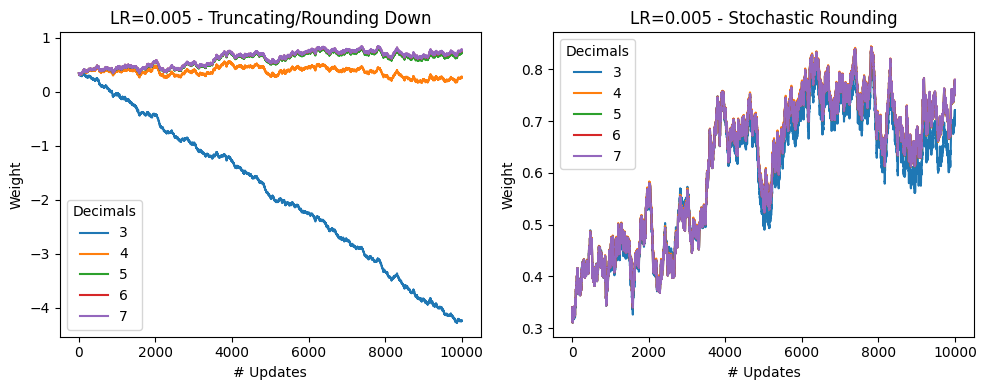

In [206]:
from matplotlib import pyplot as plt

lr = 5e-3
res = rounding_evolution(n_updates=10000, decimals=7, lr=lr)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.array(list(res[False].values())).T)
axs[0].legend(res[False].keys(), title='Decimals')
axs[0].set_title(f'LR={lr} - Truncating/Rounding Down')
axs[0].set_ylabel('Weight')
axs[0].set_xlabel('# Updates')
axs[1].plot(np.array(list(res[True].values())).T)
axs[1].legend(res[True].keys(), title='Decimals')
axs[1].set_title(f'LR={lr} - Stochastic Rounding')
axs[1].set_ylabel('Weight')
axs[1].set_xlabel('# Updates')
fig.tight_layout()

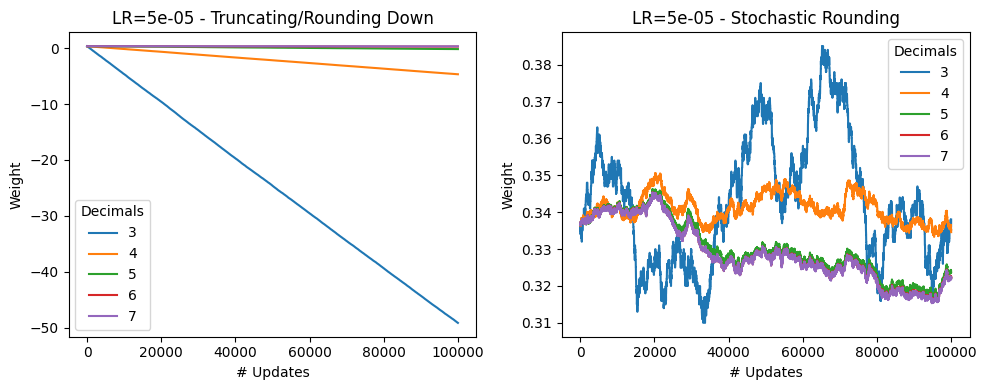

In [204]:
lr = 5e-5
res = rounding_evolution(n_updates=100000, decimals=7, lr=lr)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.array(list(res[False].values())).T)
axs[0].legend(res[False].keys(), title='Decimals')
axs[0].set_title(f'LR={lr} - Truncating/Rounding Down')
axs[0].set_ylabel('Weight')
axs[0].set_xlabel('# Updates')
axs[1].plot(np.array(list(res[True].values())).T)
axs[1].legend(res[True].keys(), title='Decimals')
axs[1].set_title(f'LR={lr} - Stochastic Rounding')
axs[1].set_ylabel('Weight')
axs[1].set_xlabel('# Updates')
fig.tight_layout()

#### PyTorch's SDPA

In [ ]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                             device_map='auto',
                                             attn_implementation="sdpa")

#### Showdown

In [ ]:
# # Adapted from https://colab.research.google.com/drive/1_zuAiiBFoFWpexxeWsTS694tCSlMYydo
def benchmark(model, inputs, n_iterations):
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

    for _ in range(n_iterations):
        _ = model(inputs)

    end_event.record()
    torch.cuda.synchronize()

    max_memory = torch.cuda.max_memory_allocated(device)

    return start_event.elapsed_time(end_event) / n_iterations, max_memory

We should restart the kernel after each run so that we can start from a clean slate.

In [5]:
repo_id = 'facebook/opt-350m'
device = torch.device("cuda:0")
attn_implementation = ['eager', 'sdpa', 'flash_attention_2']
# change it to switch to a different implementation
i = 0 # runs eager attention
# We load the model into the CPU because we're only interested
# in loading the attention mechanism into the GPU
model = AutoModelForCausalLM.from_pretrained(repo_id, device_map='cpu', 
                                     torch_dtype=torch.float16, 
                                     attn_implementation=attn_implementation[i])
# Attention mechanism in the first layer
attn = model.model.decoder.layers[0].self_attn
attn

OPTAttention(
  (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
  (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
  (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
  (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
)

In [6]:
batch_size = 2
sequence_length = 1024
shape = (batch_size, sequence_length, model.config.hidden_size)
inputs = torch.randn(shape, device=device).half()

# warmup
attn.to(device)
_ = attn(inputs)

In [ ]:
benchmark(attn, inputs, 1000)

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/attn_comparison.png?raw=True)
<center>Table 5.1 - Comparing the performance of attention’s implementations</center>

### Studies, Ablation-Style

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/mem_16_seq500.png?raw=True)

<center>Table 5.2 - Peak memory usage for a 16-bit OPT-350M and sequence length of 500</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/mem_16_seq2k.png?raw=True)

<center>Table 5.3 - Peak memory usage for a 16-bit OPT-350M and sequence length of 2,000</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/mem_8_opt.png?raw=True)

<center>Table 5.4 - Peak memory usage for a quantized OPT-350M</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/mem_8_falcon.png?raw=True)
<center>Table 5.5 - Peak memory usage for a quantized Falcon 7B</center>

### Coming Up in "Fine-Tuning LLMs"

Trading compute for memory was one of the key ingredients that led to the successful fine-tuning of the LLMs. They learned how to converse and how to efficiently pay attention to every token they receive. They’re finally ready to be deployed in the real world, where they’ll face their biggest challenge yet: the end user’s environment. Deprived of their GPUs and relying on their wits and quantization alone, they’ll be put to the test. Stay tuned for the final chapter of "Fine-Tuning LLMs."